In [3]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [4]:
from functions import helpers
from functions import models
from functions import classifiers

2024-07-03 02:35:19.483545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
FILE = 'UTK_med_data_cleaned_with_nan.csv'# this dataset do not have immutation
data_path = os.path.join('../data', FILE)
df0 = pd.read_csv(data_path, index_col=0)

/var/folders/0r/r2dplk4d72d437ygr7ycq8kw0000gn/T/ipykernel_98545/3149221205.py:3: DtypeWarning: Columns (82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(data_path, index_col=0)


In [6]:
df0.shape

(17620, 127)

In [7]:
print(df0['Labortime'].isna().sum())

6105


In [8]:
print((df0['Labortime'] == "").sum())

0


In [10]:
print(df0[['Labortime']].describe())

          Labortime
count  11515.000000
mean      63.411637
std       82.185478
min        1.000000
25%       13.000000
50%       30.000000
75%       80.000000
max      844.000000


In [11]:
print(df0['VBAC A'].isna().sum())

16865


In [12]:
print((df0['VBAC A'] == "").sum())

0


In [127]:
df = df0.dropna(subset=['Weight Delivery','Weight Prepregnancy','Height Inches'])

In [128]:
df.shape

(14319, 127)

### BMI

In [129]:
df['Weight Prepregnancy'].describe()

count    14319.000000
mean       163.902717
std         46.603559
min         70.000000
25%        130.000000
50%        153.000000
75%        186.000000
max        456.000000
Name: Weight Prepregnancy, dtype: float64

In [130]:
df['Height Inches'].describe()

count    14319.000000
mean        64.225351
std          3.061532
min         45.300000
25%         62.000000
50%         64.000000
75%         66.000000
max         96.000000
Name: Height Inches, dtype: float64

In [131]:
df['BMI_prepregnancy'].describe()

count    14319.000000
mean        27.887771
std          7.476443
min         13.043945
25%         22.456944
50%         26.167222
75%         31.614201
max         80.767952
Name: BMI_prepregnancy, dtype: float64

In [132]:
df['BMI_delivery'].describe()

count    14319.000000
mean        33.001100
std          7.209561
min         12.466696
25%         27.808264
50%         31.746482
75%         36.841522
max         84.310406
Name: BMI_delivery, dtype: float64

In [133]:
df_c = df.copy()

In [134]:
threshold = 30
df_c[ 'BMI_dm1'] = df_c['BMI_delivery'].gt(threshold).astype(int)
df_c[ 'BMI_dm0'] = df_c['BMI_prepregnancy'].gt(threshold).astype(int)

In [135]:
df = df_c

In [136]:
pd.crosstab(df['BMI_dm0'], df['BMI_dm1'], margins=True)

BMI_dm1,0,1,All
BMI_dm0,,,
0,5570,4310,9880
1,25,4414,4439
All,5595,8724,14319


### Response

##### Labor time;  Method of Delivery A; Condition A; Preterm Labor,VBAC A

In [137]:
print(df[['Labortime','Labortime_3']].describe())

        Labortime  Labortime_3
count  9301.00000  9326.000000
mean     65.20858     6.379798
std      82.34967    14.641015
min       1.00000     1.000000
25%      14.00000     3.000000
50%      32.00000     4.000000
75%      83.00000     7.000000
max     844.00000   740.000000


In [138]:
result = df.groupby(['BMI_dm0', 'BMI_dm1']).agg({
    'Labortime': ['mean', 'std'],  # Calculate mean and std deviation
    'Labortime_3': ['mean', 'std']
})

print(result)

                 Labortime            Labortime_3           
                      mean        std        mean        std
BMI_dm0 BMI_dm1                                             
0       0        62.429251  79.380827    6.381559  14.235358
        1        70.287729  84.873794    6.360056  13.879402
1       0        15.000000   9.446204    5.428571   2.173770
        1        64.149308  84.026393    6.405109  16.117851


In [189]:
df.groupby(['BMI_dm0']).agg({
    'Labortime': ['mean', 'std'],  # Calculate mean and std deviation
    'Labortime_3': ['mean', 'std']
})

Labortime           Labortime_3           
              mean       std        mean        std
BMI_dm0                                            
0        65.692781  81.79245    6.372626  14.087561
1        63.870955  83.87199    6.399597  16.073211

In [139]:
df['Method of Delivery A'].value_counts(dropna=False)

Vag    9840
C/S    4477
NaN       2
Name: Method of Delivery A, dtype: int64

In [140]:
df['Condition A'].value_counts(dropna=False)

Stable            13547
Fair                505
IUFD                111
Critical            108
NaN                  25
Neonatal Death       23
Name: Condition A, dtype: int64

In [141]:
df['Preterm Labor'].value_counts(dropna=False)

No     12928
Yes      892
NaN      499
Name: Preterm Labor, dtype: int64

In [142]:
df['VBAC A'].value_counts(dropna=False)

NaN        13774
Success      422
Failed       123
Name: VBAC A, dtype: int64

In [143]:
df[['BMI_dm0','Method of Delivery A']].value_counts()

BMI_dm0  Method of Delivery A
0        Vag                     7227
         C/S                     2651
1        Vag                     2613
         C/S                     1826
dtype: int64

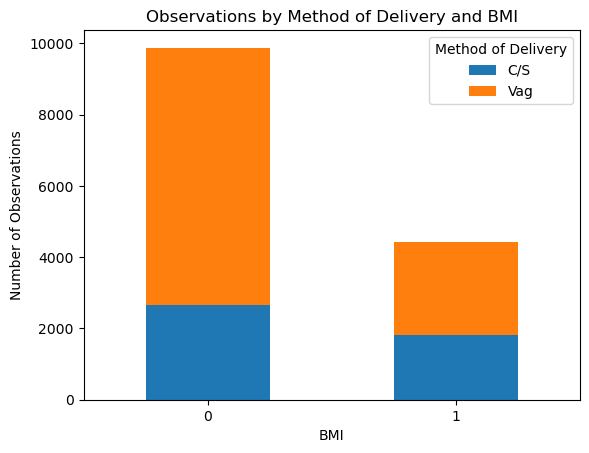

In [397]:
# Prepare the data
plot_data = pd.crosstab(index=df['BMI_dm0'], columns=df['Method of Delivery A'])

# Plotting
plot_data.plot(kind='bar', stacked=True)
plt.title('Observations by Method of Delivery and BMI')
plt.xlabel('BMI')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)  # Rotate x-axis labels to horizontal
plt.legend(title='Method of Delivery')
plt.show()

In [144]:
df[['BMI_dm0','Condition A']].value_counts()

BMI_dm0  Condition A   
0        Stable            9420
1        Stable            4127
0        Fair               293
1        Fair               212
0        IUFD                73
         Critical            65
1        Critical            43
         IUFD                38
0        Neonatal Death      13
1        Neonatal Death      10
dtype: int64

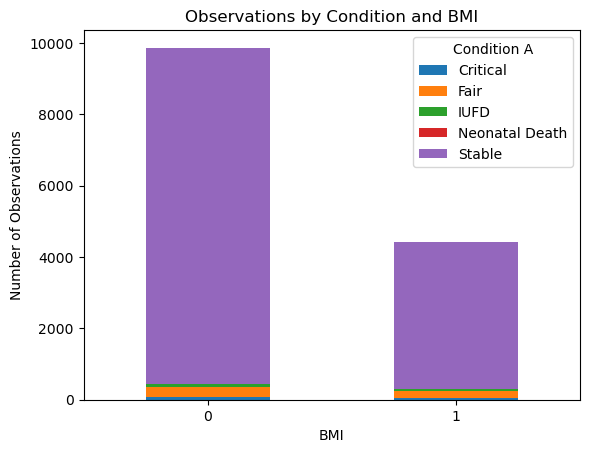

In [398]:
# Prepare the data
plot_data = pd.crosstab(index=df['BMI_dm0'], columns=df['Condition A'])

# Plotting
plot_data.plot(kind='bar', stacked=True)
plt.title('Observations by Condition and BMI')
plt.xlabel('BMI')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)  # Rotate x-axis labels to horizontal
plt.legend(title='Condition A')
plt.show()

In [145]:
df[['BMI_dm0','Preterm Labor']].value_counts()

BMI_dm0  Preterm Labor
0        No               8881
1        No               4047
0        Yes               635
1        Yes               257
dtype: int64

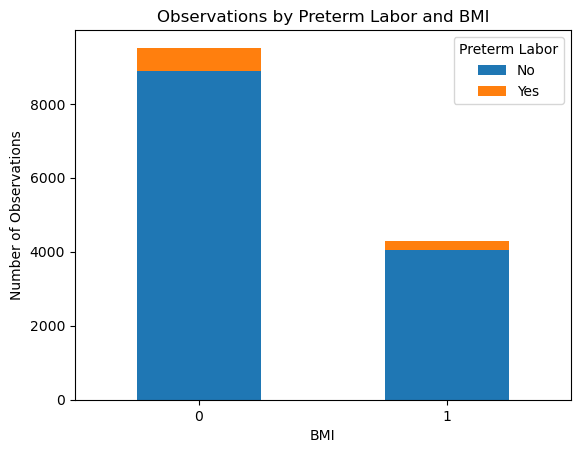

In [399]:
# Prepare the data
plot_data = pd.crosstab(index=df['BMI_dm0'], columns=df['Preterm Labor'])

# Plotting
plot_data.plot(kind='bar', stacked=True)
plt.title('Observations by Preterm Labor and BMI')
plt.xlabel('BMI')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)  # Rotate x-axis labels to horizontal
plt.legend(title='Preterm Labor')
plt.show()

In [116]:
df[['BMI_dm0','VBAC A']].value_counts()

BMI_dm0  VBAC A 
0        Success    303
1        Success    119
0        Failed      71
1        Failed      52
dtype: int64

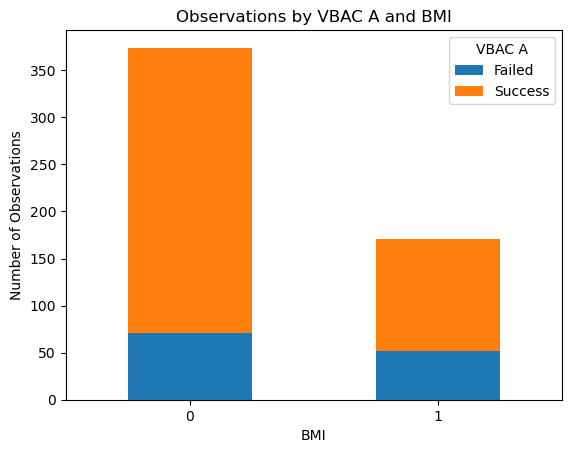

In [400]:
# Prepare the data
plot_data = pd.crosstab(index=df['BMI_dm0'], columns=df['VBAC A'])

# Plotting
plot_data.plot(kind='bar', stacked=True)
plt.title('Observations by VBAC A and BMI')
plt.xlabel('BMI')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)  # Rotate x-axis labels to horizontal
plt.legend(title='VBAC A')
plt.show()

In [404]:
plot_data

VBAC A,Failed,Success
BMI_dm0,,
0,71,303
1,52,119


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (1).

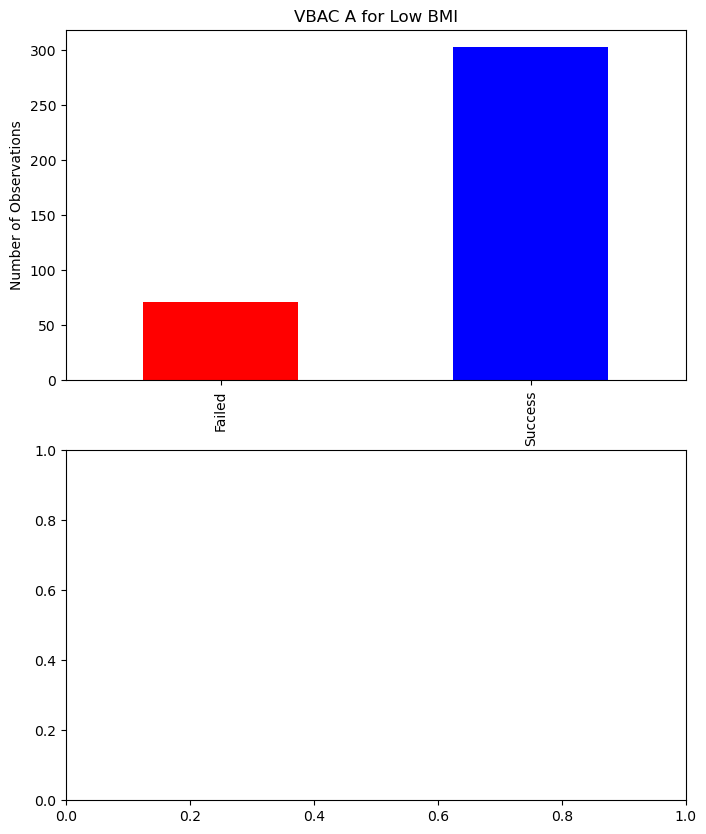

In [405]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))  # Adjust figsize to fit your screen

# Plotting data for 'low' BMI
plot_data.loc[0].plot(kind='bar', ax=axes[0], color=['red', 'blue'])
axes[0].set_title('VBAC A for Low BMI')
axes[0].set_ylabel('Number of Observations')
axes[0].set_xticklabels(['Low BMI'], rotation=0)  # Prevents rotation of x-tick labels

# Plotting data for 'high' BMI
plot_data.loc[1].plot(kind='bar', ax=axes[1], color=['red', 'blue'])
axes[1].set_title('VBAC A for High BMI')
axes[1].set_ylabel('Number of Observations')
axes[1].set_xticklabels(['High BMI'], rotation=0)  # Prevents rotation of x-tick labels

# Adding space between plots for clarity
plt.tight_layout(pad=3.0)
plt.show()

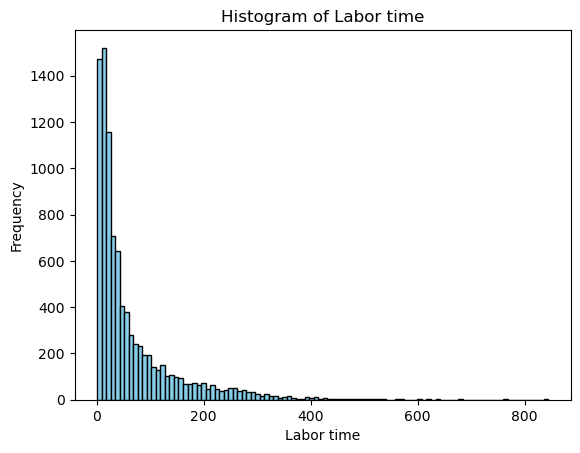

In [146]:
plt.hist(df['Labortime'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Labor time')
plt.ylabel('Frequency')
plt.title('Histogram of Labor time')
plt.show()

In [147]:
# Shapiro-Wilk test
shapiro_stat, shapiro_p = st.shapiro(df['Labortime'])
print(f"Shapiro-Wilk Test: Test Statistic = {shapiro_stat}, p-value = {shapiro_p}")

# Kolmogorov-Smirnov test
ks_stat, ks_p = st.kstest(df['Labortime'], 'norm')
print(f"Kolmogorov-Smirnov Test: Test Statistic = {ks_stat}, p-value = {ks_p}")

Shapiro-Wilk Test: Test Statistic = nan, p-value = 1.0
Kolmogorov-Smirnov Test: Test Statistic = nan, p-value = nan


/Users/menglinghe/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [148]:
df['lbtime_log'] = np.log(df['Labortime'])

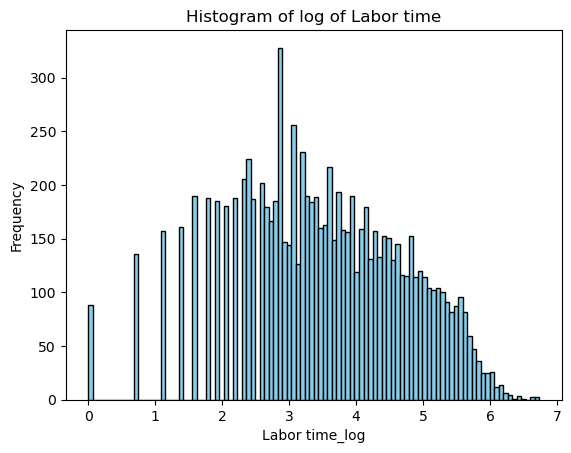

In [149]:
plt.hist(df['lbtime_log'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Labor time_log')
plt.ylabel('Frequency')
plt.title('Histogram of log of Labor time')
plt.show()

Text(0.5, 1.0, 'Q-Q Plot')

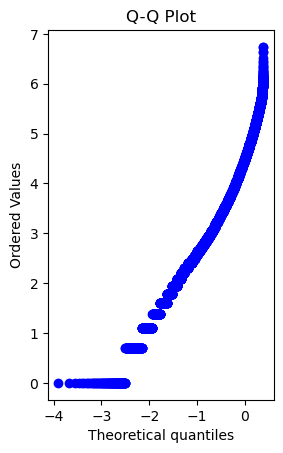

In [150]:
# Q-Q plot
plt.subplot(1, 2, 2)
st.probplot(df['lbtime_log'], dist="norm", plot=plt)
plt.title('Q-Q Plot')

In [151]:
# Shapiro-Wilk test
shapiro_stat, shapiro_p = st.shapiro(df['lbtime_log'])
print(f"Shapiro-Wilk Test: Test Statistic = {shapiro_stat}, p-value = {shapiro_p}")

# Kolmogorov-Smirnov test
ks_stat, ks_p = st.kstest(df['lbtime_log'], 'norm')
print(f"Kolmogorov-Smirnov Test: Test Statistic = {ks_stat}, p-value = {ks_p}")

Shapiro-Wilk Test: Test Statistic = nan, p-value = 1.0
Kolmogorov-Smirnov Test: Test Statistic = nan, p-value = nan


/Users/menglinghe/anaconda3/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


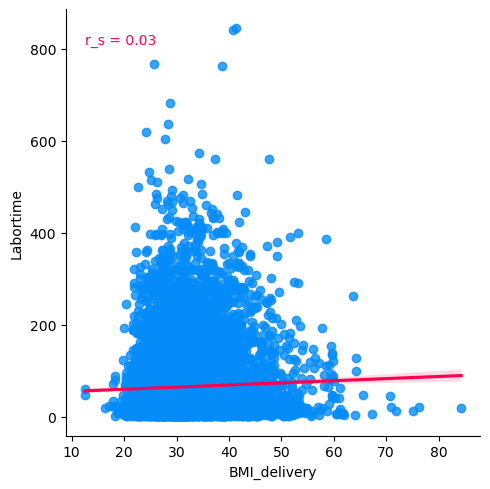

In [152]:
rho, p = st.spearmanr(df['BMI_delivery'], df['Labortime'], nan_policy='omit')
ax = sns.lmplot(df, x='BMI_delivery', y='Labortime', scatter_kws={'color': '#068cf9'}, line_kws={'color': '#ff0051'})
ax.fig.text(0.18, 0.9, 'r_s = '+str(round(rho, 3)), color='#ff0051');

In [153]:
print(p)

0.004232360605105501


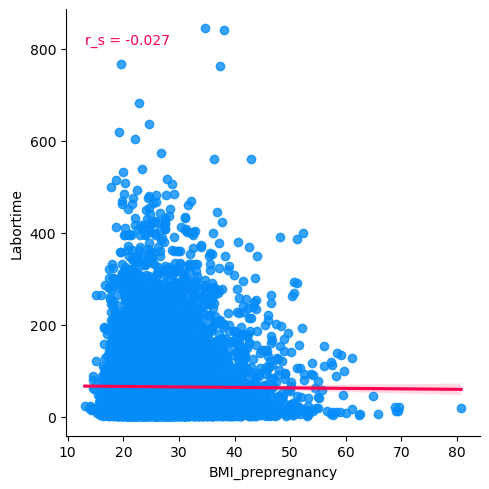

In [154]:
rho, p = st.spearmanr(df['BMI_prepregnancy'], df['Labortime'], nan_policy='omit')
ax = sns.lmplot(df, x='BMI_prepregnancy', y='Labortime', scatter_kws={'color': '#068cf9'}, line_kws={'color': '#ff0051'})
ax.fig.text(0.18, 0.9, 'r_s = '+str(round(rho, 3)), color='#ff0051');

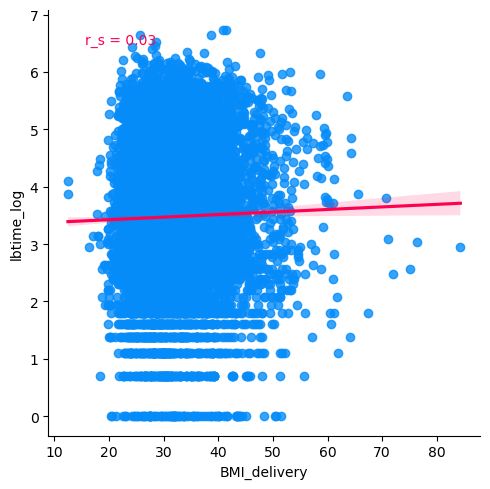

In [155]:
rho, p = st.spearmanr(df['BMI_delivery'], df['lbtime_log'], nan_policy='omit')
ax = sns.lmplot(df, x='BMI_delivery', y='lbtime_log', scatter_kws={'color': '#068cf9'}, line_kws={'color': '#ff0051'})
ax.fig.text(0.18, 0.9, 'r_s = '+str(round(rho, 3)), color='#ff0051');

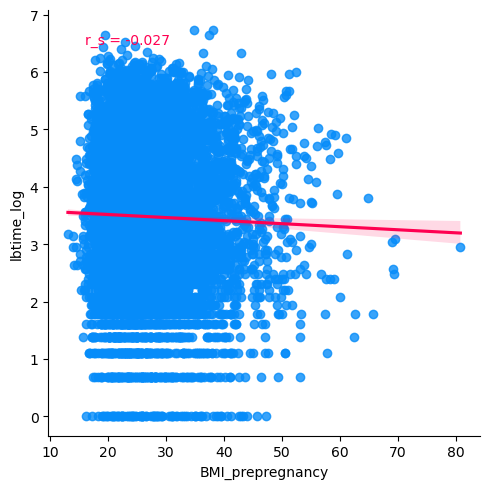

In [156]:
rho, p = st.spearmanr(df['BMI_prepregnancy'], df['lbtime_log'], nan_policy='omit')
ax = sns.lmplot(df, x='BMI_prepregnancy', y='lbtime_log', scatter_kws={'color': '#068cf9'}, line_kws={'color': '#ff0051'})
ax.fig.text(0.18, 0.9, 'r_s = '+str(round(rho, 3)), color='#ff0051');

### missing percentage of other variables

In [157]:
missing_percentage=df.isnull().mean().round(4).mul(100)

In [158]:
print(missing_percentage[missing_percentage>50])

Laceration Extension          57.83
Attempt to Vbac               82.60
Csection Incidence            68.75
Csection Urgency              68.82
Reason For Csection           68.80
Forceps a                     97.75
Vacuum Extraction A           97.19
VBAC A                        96.19
APGAR 10 minutes A            97.49
Cervical Ripening Agents      73.85
Comments Diabetes             80.45
Pitocin Start Date Time       97.71
Adm Illicit Drugs Text        91.60
CS Called Date Time           87.72
Reason For Admission Other    86.17
QBL2 hrs PP                   81.89
Units RBCS Transfused         97.67
Total Units RBCS Received     97.78
QBL Total LD                  84.64
dtype: float64


<Axes: xlabel='BMI_dm1', ylabel='Labortime'>

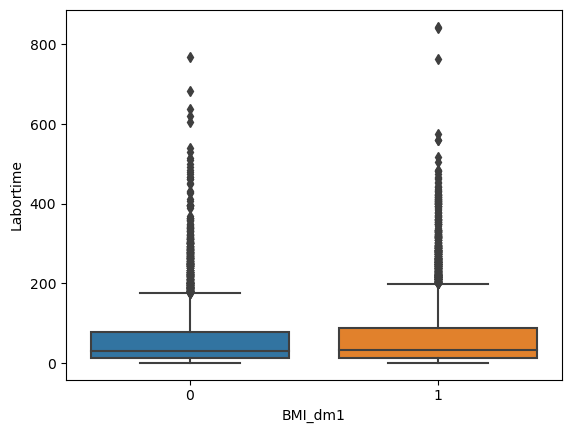

In [159]:
sns.boxplot(data=df, x='BMI_dm1', y='Labortime')

In [160]:
model = ols('Labortime ~ C(BMI_dm1)', data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=1)

In [161]:
print(anova_results)

                df        sum_sq       mean_sq         F   PR(>F)
C(BMI_dm1)     1.0  6.105872e+04  61058.722776  9.011518  0.00269
Residual    9299.0  6.300659e+07   6775.631211       NaN      NaN


In [162]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Labortime   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.012
Date:                Sun, 12 May 2024   Prob (F-statistic):            0.00269
Time:                        22:06:13   Log-Likelihood:                -54219.
No. Observations:                9301   AIC:                         1.084e+05
Df Residuals:                    9299   BIC:                         1.085e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          62.2635      1.300     47.882      0.000      59.715      64.813
C(BMI_dm1)[T.1]     5.1741      1.724      3.002      0.003       1.795       8.553
==============================================================================
Omnibus:                     4893.443   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36146.000
Skew:                           2.455   Prob(JB):                         0.00
Kurtosis:                      11.316   Cond. No.                         2.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='BMI_dm0', ylabel='Labortime'>

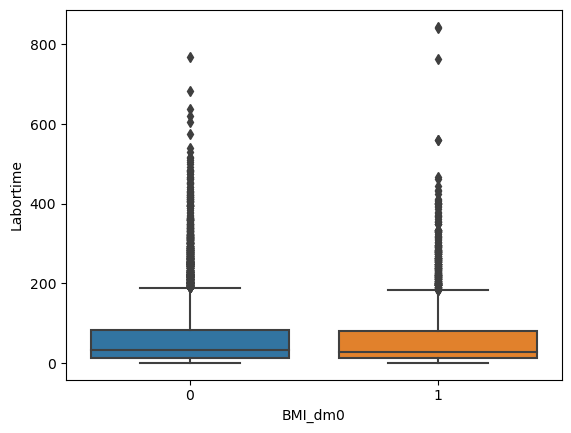

In [163]:
sns.boxplot(data=df, x='BMI_dm0', y='Labortime')

In [164]:
model = ols('Labortime ~ C(BMI_dm0)', data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=1)

In [165]:
print(anova_results)

                df        sum_sq      mean_sq         F    PR(>F)
C(BMI_dm0)     1.0  6.024067e+03  6024.066698  0.888302  0.345962
Residual    9299.0  6.306163e+07  6781.549552       NaN       NaN


In [42]:
#df['BMI_dm1_m'] = pd.cut(df['BMI_delivery'], bins=[0, 10, 20,30,40,50,60,70,80, float('Inf')],labels=['0', '1', '2','3','4','5','6','7','8'])

<Axes: xlabel='BMI_dm1_m', ylabel='lbtime_log'>

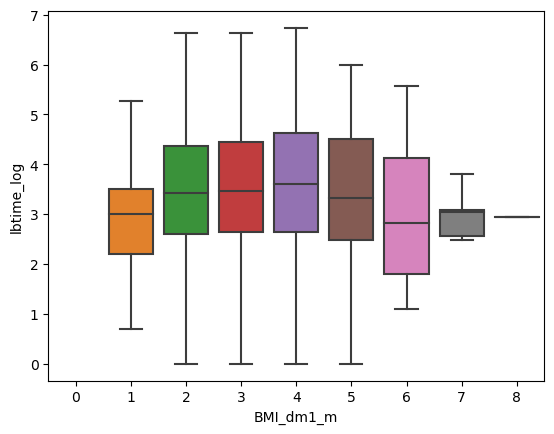

In [43]:
#sns.boxplot(data=df, x='BMI_dm1_m', y='lbtime_log')

<Axes: xlabel='BMI_dm1', ylabel='lbtime_log'>

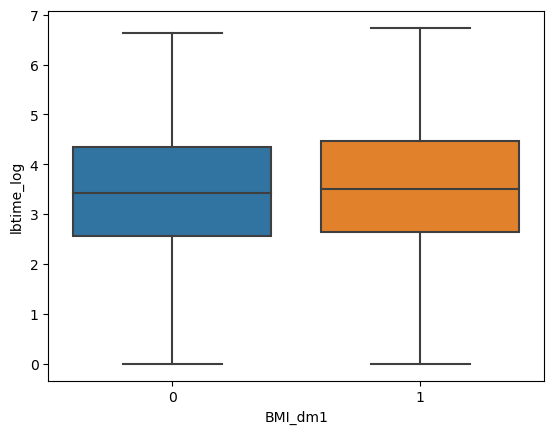

In [166]:
sns.boxplot(data=df, x='BMI_dm1', y='lbtime_log')

In [167]:
model = ols('lbtime_log ~ C(BMI_dm1)', data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=1)

In [168]:
print(anova_results)

                df        sum_sq   mean_sq         F    PR(>F)
C(BMI_dm1)     1.0      6.982636  6.982636  4.453225  0.034862
Residual    9299.0  14580.787545  1.567995       NaN       NaN


In [169]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lbtime_log   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.453
Date:                Sun, 12 May 2024   Prob (F-statistic):             0.0349
Time:                        22:07:26   Log-Likelihood:                -15288.
No. Observations:                9301   AIC:                         3.058e+04
Df Residuals:                    9299   BIC:                         3.059e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.4475      0.020    174.276      0.000       3.409       3.486
C(BMI_dm1)[T.1]     0.0553      0.026      2.110      0.035       0.004       0.107
==============================================================================
Omnibus:                      113.885   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.966
Skew:                          -0.162   Prob(JB):                     2.91e-20
Kurtosis:                       2.643   Cond. No.                         2.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [170]:
np.exp(0.0553)

1.0568576244089793

<Axes: xlabel='BMI_dm0', ylabel='lbtime_log'>

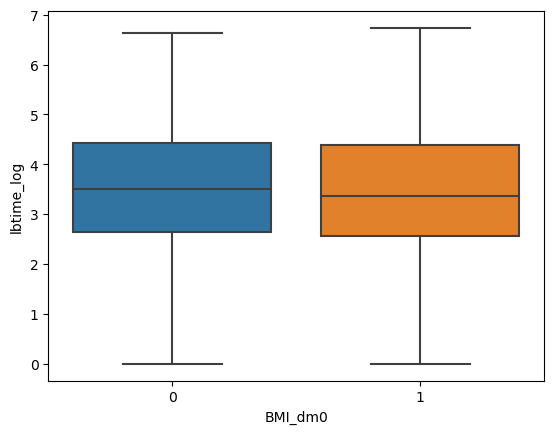

In [171]:
sns.boxplot(data=df, x='BMI_dm0', y='lbtime_log')

In [190]:
df.groupby(['BMI_dm0']).agg({
    'lbtime_log': ['mean', 'std']
})

lbtime_log          
              mean       std
BMI_dm0                     
0         3.500452  1.240907
1         3.419609  1.282104

In [172]:
model = ols('lbtime_log ~ C(BMI_dm0)', data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=1)

In [173]:
print(anova_results)

                df        sum_sq    mean_sq        F    PR(>F)
C(BMI_dm0)     1.0     11.861802  11.861802  7.56748  0.005955
Residual    9299.0  14575.908380   1.567471      NaN       NaN


In [174]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lbtime_log   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.567
Date:                Sun, 12 May 2024   Prob (F-statistic):            0.00595
Time:                        22:07:36   Log-Likelihood:                -15287.
No. Observations:                9301   AIC:                         3.058e+04
Df Residuals:                    9299   BIC:                         3.059e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5005      0.015    231.048      0.000       3.471       3.530
C(BMI_dm0)[T.1]    -0.0808      0.029     -2.751      0.006      -0.138      -0.023
==============================================================================
Omnibus:                      112.578   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.216
Skew:                          -0.157   Prob(JB):                     6.98e-20
Kurtosis:                       2.641   Cond. No.                         2.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [320]:
df['BMI_combine'] = df['BMI_dm0']  + df['BMI_dm1'] * 2 # This will give you 0, 1, 2, 3
# 0: low BMI
# 1: high BMI at pregnancy, Low BMI at delivery
# 2: low BMI at pregnancy, high BMI at delivery
# 3: high BMI

In [321]:
df['BMI_combine'] =df['BMI_combine'].astype('category')
df['BMI_combine'].value_counts()

0    5570
3    4414
2    4310
1      25
Name: BMI_combine, dtype: int64

In [322]:
# Create dummy variables
dummies = pd.get_dummies(df['BMI_combine'], prefix='BMI_combine')


In [323]:
# Concatenate with the original DataFrame
df = pd.concat([df, dummies], axis=1)

In [185]:
contingency_table = pd.crosstab(df['BMI_dm0'], df['Method of Delivery A'])
print("Contingency Table:")
print(contingency_table)
chi2, p, dof, expected = st.chi2_contingency(contingency_table)
print("\nChi2 Stat:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected counts:")
print(expected)

Contingency Table:
Method of Delivery A   C/S   Vag
BMI_dm0                         
0                     2651  7227
1                     1826  2613

Chi2 Stat: 290.656941012021
P-value: 3.576147016434855e-65
Degrees of freedom: 1
Expected counts:
[[3088.90172522 6789.09827478]
 [1388.09827478 3050.90172522]]


If the p-value is less than 0.05 (assuming a 5% significance level), you can reject the null hypothesis, concluding that there is a significant association between gender and fruit preference.

In [184]:
contingency_table = pd.crosstab(df['BMI_dm0'], df['Condition A'])
print("Contingency Table:")
print(contingency_table)
chi2, p, dof, expected = st.chi2_contingency(contingency_table)
print("\nChi2 Stat:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected counts:")
print(expected)

Contingency Table:
Condition A  Critical  Fair  IUFD  Neonatal Death  Stable
BMI_dm0                                                  
0                  65   293    73              13    9420
1                  43   212    38              10    4127

Chi2 Stat: 36.426784407553875
P-value: 2.3638957360396326e-07
Degrees of freedom: 4
Expected counts:
[[7.45286134e+01 3.48490276e+02 7.65988527e+01 1.58718343e+01
  9.34851042e+03]
 [3.34713866e+01 1.56509724e+02 3.44011473e+01 7.12816566e+00
  4.19848958e+03]]


In [186]:
contingency_table = pd.crosstab(df['BMI_dm0'], df['Preterm Labor'])
print("Contingency Table:")
print(contingency_table)
chi2, p, dof, expected = st.chi2_contingency(contingency_table)
print("\nChi2 Stat:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected counts:")
print(expected)

Contingency Table:
Preterm Labor    No  Yes
BMI_dm0                 
0              8881  635
1              4047  257

Chi2 Stat: 2.3025369959162596
P-value: 0.12916287748661226
Degrees of freedom: 1
Expected counts:
[[8901.79797395  614.20202605]
 [4026.20202605  277.79797395]]


In [187]:
contingency_table = pd.crosstab(df['BMI_dm0'], df['VBAC A'])
print("Contingency Table:")
print(contingency_table)
chi2, p, dof, expected = st.chi2_contingency(contingency_table)
print("\nChi2 Stat:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected counts:")
print(expected)

Contingency Table:
VBAC A   Failed  Success
BMI_dm0                 
0            71      303
1            52      119

Chi2 Stat: 8.124145544827394
P-value: 0.004367956516150099
Degrees of freedom: 1
Expected counts:
[[ 84.40733945 289.59266055]
 [ 38.59266055 132.40733945]]


In [325]:
df.columns

Index(['Age', 'County', 'Gravida', 'Para', 'Delivery Anesthesia',
       'Labor Anesthesia', 'Episiotomy', 'Laceration Extension',
       'Laceration Type', 'Amniotic Fluid Color',
       ...
       'race_american_indian', 'race_other', 'BMI_dm1', 'BMI_dm0',
       'lbtime_log', 'BMI_combine', 'BMI_combine_0', 'BMI_combine_1',
       'BMI_combine_2', 'BMI_combine_3'],
      dtype='object', length=135)

#### include other predictors

Age
County
Gravida
Para (keep 1)
Resident (too many missing values)
Weight Prepregnancy
Weight
Weight Gain Pounds
Height Inches
Diabetes
Comments Diabetes
Adm Alcohol
Adm Cigarettes
Adm Marijuana
Adm Cocaine Crack
Adm Illicit Drugs
Adm Illicit Drugs Text
Race (do not include for now)
Ethnicity

In [326]:
predictors = ['Age','Gravida','Para','Diabetes','Adm Alcohol','Adm Cigarettes','Adm Marijuana'
             ,'Adm Cocaine Crack','Adm Illicit Drugs','Ethnicity','BMI_combine_0', 'BMI_combine_1',
       'BMI_combine_2', 'BMI_combine_3']

In [327]:
response = ['lbtime_log','Method of Delivery A','Condition A','VBAC A']

In [328]:
df_list = []
for i in range(len(response)):
    columns = [response[i],*predictors]
    df_list.append(df[columns])

In [329]:
for i in range(len(response)):
    df_list[i] = df_list[i].dropna()

In [330]:
for i in range(len(response)):
    print(len(df_list[i]))

8269
12711
12695
486


In [392]:
df1 = df_list[0]

In [393]:
X = df1[predictors]  # Predictor variables
y = df1[response[0]]  

In [394]:
X.dtypes

Age                  float64
Gravida              float64
Para                 float64
Diabetes              object
Adm Alcohol           object
Adm Cigarettes        object
Adm Marijuana         object
Adm Cocaine Crack     object
Adm Illicit Drugs     object
Ethnicity             object
BMI_combine_0          uint8
BMI_combine_1          uint8
BMI_combine_2          uint8
BMI_combine_3          uint8
dtype: object

In [395]:
X = pd.get_dummies(X, drop_first=True)

In [336]:
# Adding a constant (intercept)
X = sm.add_constant(X)

# Fitting the OLS model
model_ols = sm.OLS(y, X)
results = model_ols.fit()

# Printing the summary of the model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             lbtime_log   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     181.4
Date:                Mon, 13 May 2024   Prob (F-statistic):               0.00
Time:                        00:53:36   Log-Likelihood:                -12232.
No. Observations:                8269   AIC:                         2.450e+04
Df Residuals:                    8250   BIC:                         2.463e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.62

In [269]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_train)
mse = mean_squared_error(y_train, predictions)
print("Mean Squared Error:", mse)

# Predictions
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.1394782159679366
Mean Squared Error: 1.106080638014874


In [266]:
print("Intercept:", model.intercept_)

Intercept: 3.3335005193178864


In [267]:
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

                       Coefficient
Age                       0.020271
Gravida                  -0.050227
Para                     -0.515580
Diabetes_Yes              0.069090
Adm Alcohol_YES           0.025011
Adm Cigarettes_former     0.143337
Adm Cigarettes_light      0.169647
Adm Cigarettes_never      0.173931
Adm Cigarettes_vape       1.719577
Adm Marijuana_YES        -0.112787
Adm Cocaine Crack_YES    -0.165613
Adm Illicit Drugs_YES     0.259500
Ethnicity_H               0.105992
Ethnicity_O               0.104307
Ethnicity_U               0.283504


In [382]:
df2 = df_list[1]
X = df2[predictors]  # Predictor variables
y = df2[response[1]]  # Numerical response variable

In [383]:
X.dtypes

Age                  float64
Gravida              float64
Para                 float64
Diabetes              object
Adm Alcohol           object
Adm Cigarettes        object
Adm Marijuana         object
Adm Cocaine Crack     object
Adm Illicit Drugs     object
Ethnicity             object
BMI_combine_0          uint8
BMI_combine_1          uint8
BMI_combine_2          uint8
BMI_combine_3          uint8
dtype: object

In [384]:
X = pd.get_dummies(X, drop_first=True)

In [386]:
X.columns

Index(['Age', 'Gravida', 'Para', 'BMI_combine_0', 'BMI_combine_1',
       'BMI_combine_2', 'BMI_combine_3', 'Diabetes_Yes', 'Adm Alcohol_YES',
       'Adm Cigarettes_former', 'Adm Cigarettes_light', 'Adm Cigarettes_never',
       'Adm Cigarettes_vape', 'Adm Marijuana_YES', 'Adm Cocaine Crack_YES',
       'Adm Illicit Drugs_YES', 'Ethnicity_H', 'Ethnicity_O', 'Ethnicity_U'],
      dtype='object')

In [345]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.6869838773102634


/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [349]:
print("Intercept:", model.intercept_)
print("Coefficients:", coefficients)

Intercept: [1.63783056]
Coefficients:          0         1         2         3         4         5         6   \
0 -0.058383 -0.083114  0.243242  0.842878  0.238833  0.474537  0.002989   

         7         8         9         10        11        12        13  \
0 -0.365443 -0.287329  0.006168  0.042775  0.178414 -0.035011  0.043199   

         14        15        16        17        18  
0  0.192542 -0.131213  0.330589  0.248968  0.408061  


In [355]:
y.value_counts()

Vag    8727
C/S    3984
Name: Method of Delivery A, dtype: int64

In [356]:
y = y.map({'C/S': 1, 'Vag': 0})

# Add constant to the feature set for the intercept
X_with_const = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()

# Print the summary of the regression
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.592427
         Iterations 5
                            Logit Regression Results                            
Dep. Variable:     Method of Delivery A   No. Observations:                12711
Model:                            Logit   Df Residuals:                    12692
Method:                             MLE   Df Model:                           18
Date:                  Mon, 13 May 2024   Pseudo R-squ.:                 0.04727
Time:                          06:10:17   Log-Likelihood:                -7530.3
converged:                         True   LL-Null:                       -7903.9
Covariance Type:              nonrobust   LLR p-value:                5.487e-147
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.9125   1.37e+06  -1.39e-06      1.000   -2

In [390]:
X_train, X_test, y_train, y_test = helpers.split_and_scale_data(X, y)

In [391]:
y_train.value_counts()

Vag    6110
C/S    2787
Name: Method of Delivery A, dtype: int64

In [370]:
df3 = df_list[2]
df3[response[2]]   = pd.Categorical(df3[response[2]])
X = df3[predictors]  # Predictor variables
y = df3[response[2]].cat.codes 

In [371]:
y.value_counts()

4    12046
1      435
2       98
0       95
3       21
dtype: int64

In [372]:
# Select only non-numerical columns
categorical_df = X.select_dtypes(include=['object'])
# Convert categorical columns to dummies
dummies = pd.get_dummies(categorical_df, drop_first=True)  # Using drop_first to avoid multicollinearity
# Drop original non-numerical columns from df
X.drop(categorical_df.columns, axis=1, inplace=True)
# Concatenate the original DataFrame and the new dummy columns
X = pd.concat([X, dummies], axis=1)

/var/folders/0r/r2dplk4d72d437ygr7ycq8kw0000gn/T/ipykernel_81447/840215723.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(categorical_df.columns, axis=1, inplace=True)


In [373]:
X.shape

(12695, 19)

In [374]:
# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Fitting the multinomial logistic regression model
model = sm.MNLogit(y, X)
result = model.fit()

# Print the summary of the regression
print(result.summary())

TypeError: MultiIndex.name must be a hashable type

In [357]:
df2 = df_list[3]
X = df2[predictors]  # Predictor variables
y = df2[response[3]]  # Numerical response variable

In [358]:
y.value_counts()

Success    375
Failed     111
Name: VBAC A, dtype: int64

In [359]:
y = y.map({'Success': 1, 'Failed': 0})

In [360]:
# Select only non-numerical columns
categorical_df = X.select_dtypes(include=['object'])
# Convert categorical columns to dummies
dummies = pd.get_dummies(categorical_df, drop_first=True)  # Using drop_first to avoid multicollinearity
# Drop original non-numerical columns from df
X.drop(categorical_df.columns, axis=1, inplace=True)
# Concatenate the original DataFrame and the new dummy columns
X = pd.concat([X, dummies], axis=1)

/var/folders/0r/r2dplk4d72d437ygr7ycq8kw0000gn/T/ipykernel_81447/840215723.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(categorical_df.columns, axis=1, inplace=True)


In [361]:
X.shape

(486, 18)

In [362]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7653061224489796


/Users/menglinghe/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [363]:
# Add constant to the feature set for the intercept
X_with_const = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()

# Print the summary of the regression
print(result.summary())

         Current function value: 0.494605
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 VBAC A   No. Observations:                  486
Model:                          Logit   Df Residuals:                      468
Method:                           MLE   Df Model:                           17
Date:                Mon, 13 May 2024   Pseudo R-squ.:                 0.07951
Time:                        06:16:05   Log-Likelihood:                -240.38
converged:                      False   LL-Null:                       -261.14
Covariance Type:            nonrobust   LLR p-value:                 0.0007842
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.4884   5.59e+06   8.74e-08      1.000    -1.1e+07     1.1e+07
Age                      -0.0187

/Users/menglinghe/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


###  Gravida and BMI

In [62]:
df['Gravida'].value_counts()

1.0     3158
2.0     2559
3.0     1638
4.0      990
5.0      449
6.0      248
7.0      116
8.0       61
9.0       41
10.0      19
12.0       7
13.0       4
11.0       4
20.0       2
14.0       1
17.0       1
15.0       1
Name: Gravida, dtype: int64

In [63]:
threshold_g = 1
df['Gravida_c'] = df['Gravida'].gt(threshold_g).astype(int)
df['Gravida_c'].value_counts()

1    6141
0    3160
Name: Gravida_c, dtype: int64

In [64]:
df_g = df.dropna(subset=['Gravida'])

In [65]:
df_g.shape

(9299, 128)

In [66]:
df_g['Gravida_c'].value_counts()

1    6141
0    3158
Name: Gravida_c, dtype: int64

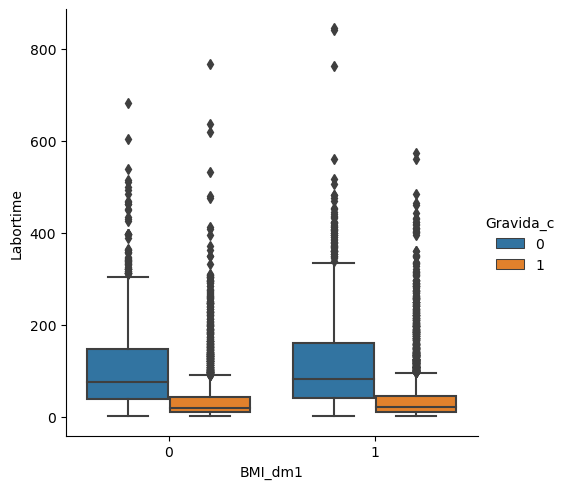

In [67]:
sns.catplot(data=df_g, x='BMI_dm1', y='Labortime', hue='Gravida_c', kind='box');

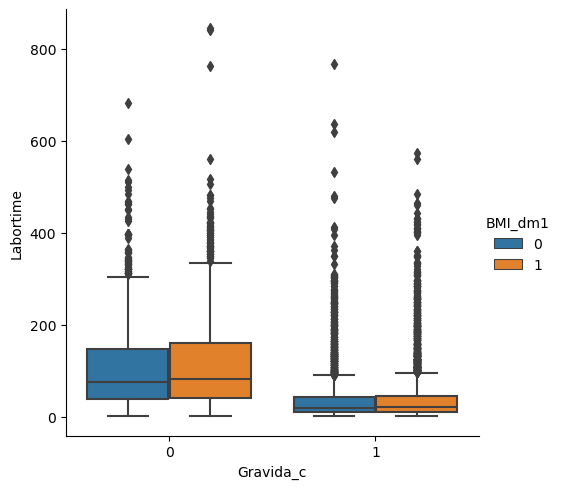

In [68]:
sns.catplot(data=df_g, x='Gravida_c', y='Labortime', hue='BMI_dm1', kind='box');

In [69]:
model = ols('Labortime ~ C(BMI_dm1) + C(Gravida_c) + C(BMI_dm1):C(Gravida_c)', data=df_g).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                               sum_sq      df            F    PR(>F)
C(BMI_dm1)               4.933560e+04     1.0     8.651711  0.003276
C(Gravida_c)             9.983424e+06     1.0  1750.737756  0.000000
C(BMI_dm1):C(Gravida_c)  1.495698e+04     1.0     2.622922  0.105364
Residual                 5.300390e+07  9295.0          NaN       NaN


In [70]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Labortime   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     588.0
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:39:12   Log-Likelihood:                -53405.
No. Observations:                9299   AIC:                         1.068e+05
Df Residuals:                    9295   BIC:                         1.068e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           106.2063      2.061     51.542      0.000     102.167     110.245
C(BMI_dm1)[T.1]                       8.2318      2.718      3.029      0.002       2.904      13.560
C(Gravida_c)[T.1]                   -66.0955      2.527    -26.154      0.000     -71.049     -61.142
C(BMI_dm1)[T.1]:C(Gravida_c)[T.1]    -5.4124      3.342     -1.620      0.105     -11.963       1.139
==============================================================================
Omnibus:                     5170.530   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48968.896
Skew:                           2.529   Prob(JB):                         0.00
Kurtosis:                      13.040   Cond. No.                         9.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
model = ols('Labortime ~ C(BMI_dm0) + C(Gravida_c) + C(BMI_dm0):C(Gravida_c)', data=df_g).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                               sum_sq      df             F    PR(>F)
C(BMI_dm0)               2.797976e-05     1.0  4.900745e-09  0.999944
C(Gravida_c)             9.989759e+06     1.0  1.749739e+03  0.000000
C(BMI_dm0):C(Gravida_c)  3.799165e+02     1.0  6.654362e-02  0.796443
Residual                 5.306781e+07  9295.0           NaN       NaN


In [72]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Labortime   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     583.6
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:39:12   Log-Likelihood:                -53410.
No. Observations:                9299   AIC:                         1.068e+05
Df Residuals:                    9295   BIC:                         1.069e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           111.1019      1.553     71.522      0.000     108.057     114.147
C(BMI_dm0)[T.1]                      -0.6562      3.102     -0.212      0.832      -6.737       5.424
C(Gravida_c)[T.1]                   -69.4821      1.922    -36.160      0.000     -73.249     -65.715
C(BMI_dm0)[T.1]:C(Gravida_c)[T.1]     0.9756      3.782      0.258      0.796      -6.438       8.389
==============================================================================
Omnibus:                     5175.241   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49068.674
Skew:                           2.532   Prob(JB):                         0.00
Kurtosis:                      13.050   Cond. No.                         7.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

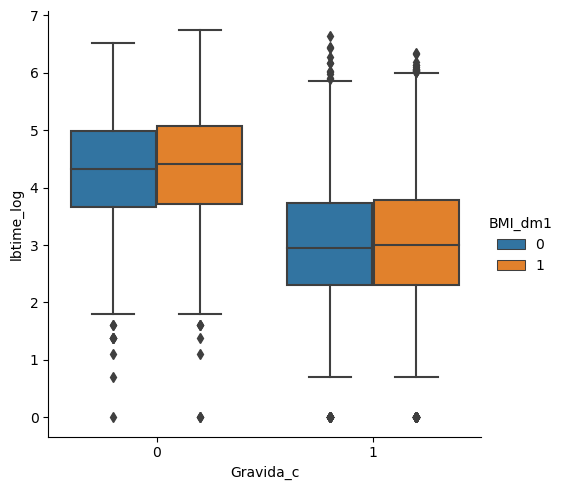

In [73]:
sns.catplot(data=df_g, x='Gravida_c', y='lbtime_log', hue='BMI_dm1', kind='box');

In [74]:
model = ols('lbtime_log ~ C(BMI_dm1) + C(Gravida_c) + C(BMI_dm1):C(Gravida_c)', data=df_g).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                               sum_sq      df            F    PR(>F)
C(BMI_dm1)                   4.709693     1.0     3.937206  0.047259
C(Gravida_c)              3460.799036     1.0  2893.156208  0.000000
C(BMI_dm1):C(Gravida_c)      0.871378     1.0     0.728454  0.393407
Residual                 11118.696930  9295.0          NaN       NaN


In [75]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lbtime_log   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     966.6
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:39:12   Log-Likelihood:                -14026.
No. Observations:                9299   AIC:                         2.806e+04
Df Residuals:                    9295   BIC:                         2.809e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             4.2882      0.030    143.686      0.000       4.230       4.347
C(BMI_dm1)[T.1]                       0.0728      0.039      1.849      0.065      -0.004       0.150
C(Gravida_c)[T.1]                    -1.2646      0.037    -34.550      0.000      -1.336      -1.193
C(BMI_dm1)[T.1]:C(Gravida_c)[T.1]    -0.0413      0.048     -0.853      0.393      -0.136       0.054
==============================================================================
Omnibus:                        9.898   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               11.071
Skew:                          -0.026   Prob(JB):                      0.00394
Kurtosis:                       3.161   Cond. No.                         9.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

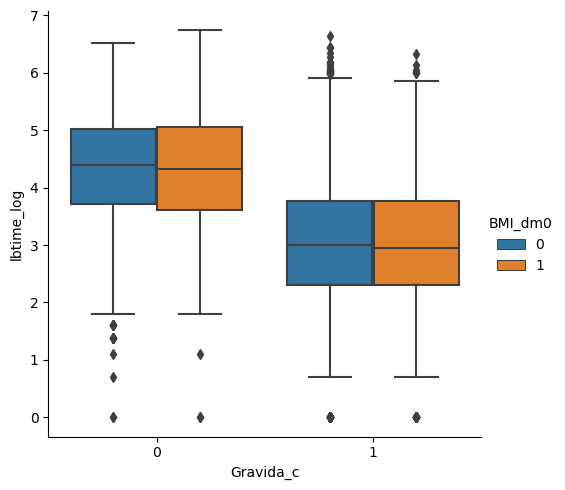

In [76]:
sns.catplot(data=df_g, x='Gravida_c', y='lbtime_log', hue='BMI_dm0', kind='box');

In [77]:
model = ols('lbtime_log ~ C(BMI_dm0) + C(Gravida_c) + C(BMI_dm0):C(Gravida_c)', data=df_g).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                               sum_sq      df            F    PR(>F)
C(BMI_dm0)                   4.055717     1.0     3.390081  0.065622
C(Gravida_c)              3455.404487     1.0  2888.293417  0.000000
C(BMI_dm0):C(Gravida_c)      0.166226     1.0     0.138944  0.709341
Residual                 11120.056058  9295.0          NaN       NaN


In [78]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lbtime_log   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     966.1
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:39:13   Log-Likelihood:                -14026.
No. Observations:                9299   AIC:                         2.806e+04
Df Residuals:                    9295   BIC:                         2.809e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             4.3454      0.022    193.243      0.000       4.301       4.389
C(BMI_dm0)[T.1]                      -0.0610      0.045     -1.359      0.174      -0.149       0.027
C(Gravida_c)[T.1]                    -1.2928      0.028    -46.479      0.000      -1.347      -1.238
C(BMI_dm0)[T.1]:C(Gravida_c)[T.1]     0.0204      0.055      0.373      0.709      -0.087       0.128
==============================================================================
Omnibus:                        9.387   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.509
Skew:                          -0.022   Prob(JB):                      0.00522
Kurtosis:                       3.159   Cond. No.                         7.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
model = ols('lbtime_log ~ C(BMI_dm0) +C(BMI_dm1)+ C(Gravida_c) + C(BMI_dm0):C(Gravida_c)+C(BMI_dm1):C(Gravida_c)++C(BMI_dm1):C(BMI_dm0)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                               sum_sq      df            F    PR(>F)
C(BMI_dm0)                  13.548493     1.0    11.341155  0.000761
C(BMI_dm1)                  14.037968     1.0    11.750884  0.000611
C(Gravida_c)              3434.281035     1.0  2874.763602  0.000000
C(BMI_dm0):C(Gravida_c)      1.221639     1.0     1.022608  0.311928
C(BMI_dm1):C(Gravida_c)      1.722354     1.0     1.441746  0.229888
C(BMI_dm1):C(BMI_dm0)        4.750377     1.0     3.976439  0.046170
Residual                 11102.898309  9294.0          NaN       NaN


In [80]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lbtime_log   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     486.2
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:39:13   Log-Likelihood:                -14021.
No. Observations:                9301   AIC:                         2.806e+04
Df Residuals:                    9294   BIC:                         2.811e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             4.2888      0.030    143.794      0.000       4.230       4.347
C(BMI_dm0)[T.1]                      -0.7253      0.299     -2.429      0.015      -1.311      -0.140
C(BMI_dm1)[T.1]                       0.1308      0.045      2.885      0.004       0.042       0.220
C(Gravida_c)[T.1]                    -1.2619      0.037    -34.481      0.000      -1.334      -1.190
C(BMI_dm0)[T.1]:C(Gravida_c)[T.1]     0.0643      0.064      1.011      0.312      -0.060       0.189
C(BMI_dm1)[T.1]:C(Gravida_c)[T.1]    -0.0675      0.056     -1.201      0.230      -0.178       0.043
C(BMI_dm1)[T.1]:C(BMI_dm0)[T.1]       0.5879      0.295      1.994      0.046       0.010       1.166
==============================================================================
Omnibus:                        9.835   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               11.043
Skew:                          -0.023   Prob(JB):                      0.00400
Kurtosis:                       3.162   Cond. No.                         57.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For nullipara, compared with low BMI patients:
low BMI at pregnancy and high BMI at delivery patient, tends to have 13.97% longer labor time.
high BMI at pregnancy and low BMI at delivery patient, tends to have 51.44% shorter labor time.
high BMI at pregnancy and high BMI at delivery patient, tends to have 0.35% shorter labor time.

For multipara, compared with low BMI patients:
low BMI at pregnancy and high BMI at delivery patient, tends to have 6.53% longer labor time.
high BMI at pregnancy and low BMI at delivery patient, tends to have 48.38% shorter labor time.
high BMI at pregnancy and high BMI at delivery patient, tends to have 0.99% shorter labor time.


The overall interpretation of these diagnostics suggests that the residuals from the regression may not be normally distributed (considering the Omnibus and Jarque-Bera tests), but there does not appear to be a significant issue with autocorrelation or asymmetry. However, there may be concerns with multicollinearity due to the high Condition Number.

In [81]:
# Create a dictionary to map numeric values to fruit names
category_names = {0: '[0,0]', 1: '[1,0]', 2: '[0,1]',3: '[1,1]'}
df_g['BMI_combine2'] = df['BMI_combine'].map(category_names)

/var/folders/0r/r2dplk4d72d437ygr7ycq8kw0000gn/T/ipykernel_28402/3720787722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_g['BMI_combine2'] = df['BMI_combine'].map(category_names)


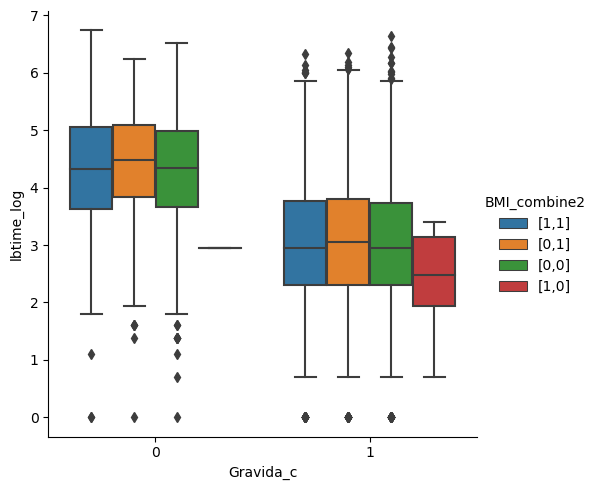

In [82]:
sns.catplot(data=df_g, x='Gravida_c', y='lbtime_log', hue='BMI_combine2', kind='box');

In [83]:
model = ols('lbtime_log ~ C(BMI_combine)+ C(Gravida_c) + C(BMI_combine):C(Gravida_c)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                                   sum_sq      df            F    PR(>F)
C(BMI_combine)                  22.701794     3.0     6.333951  0.000276
C(Gravida_c)                  3434.281035     1.0  2874.561571  0.000000
C(BMI_combine):C(Gravida_c)      2.395382     3.0     0.668327  0.571396
Residual                     11102.483934  9293.0          NaN       NaN


In [84]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lbtime_log   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     416.8
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:39:14   Log-Likelihood:                -14021.
No. Observations:                9301   AIC:                         2.806e+04
Df Residuals:                    9293   BIC:                         2.811e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 4.2892      0.030    143.755      0.000       4.231       4.348
C(BMI_combine)[T.1]                      -1.3448      1.093     -1.230      0.219      -3.488       0.799
C(BMI_combine)[T.2]                       0.1297      0.045      2.860      0.004       0.041       0.219
C(BMI_combine)[T.3]                      -0.0063      0.049     -0.129      0.897      -0.102       0.090
C(Gravida_c)[T.1]                        -1.2626      0.037    -34.480      0.000      -1.334      -1.191
C(BMI_combine)[T.1]:C(Gravida_c)[T.1]     0.7316      1.135      0.645      0.519      -1.493       2.956
C(BMI_combine)[T.2]:C(Gravida_c)[T.1]    -0.0658      0.056     -1.170      0.242      -0.176       0.044
C(BMI_combine)[T.3]:C(Gravida_c)[T.1]    -0.0037      0.060     -0.062      0.951      -0.121       0.113
==============================================================================
Omnibus:                        9.877   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               11.094
Skew:                          -0.023   Prob(JB):                      0.00390
Kurtosis:                       3.163   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
model = ols('lbtime_log ~ C(BMI_combine)+ C(Gravida_c)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lbtime_log   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     728.9
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:39:14   Log-Likelihood:                -14022.
No. Observations:                9301   AIC:                         2.805e+04
Df Residuals:                    9296   BIC:                         2.809e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.3034      0.023    183.178      0.000       4.257       4.349
C(BMI_combine)[T.1]    -0.6598      0.293     -2.254      0.024      -1.234      -0.086
C(BMI_combine)[T.2]     0.0871      0.027      3.244      0.001       0.034       0.140
C(BMI_combine)[T.3]    -0.0085      0.028     -0.305      0.760      -0.063       0.046
C(Gravida_c)[T.1]      -1.2839      0.024    -53.618      0.000      -1.331      -1.237
==============================================================================
Omnibus:                        9.942   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               11.163
Skew:                          -0.024   Prob(JB):                      0.00377
Kurtosis:                       3.163   Cond. No.                         33.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
pd.crosstab(df['BMI_dm0'], df['BMI_dm1'], margins=True)

BMI_dm1,0,1,All
BMI_dm0,,,
0,3993,2836,6829
1,14,2458,2472
All,4007,5294,9301


In [88]:
pd.crosstab(df['BMI_dm0'], [df['Gravida_c'], df['BMI_dm1']], margins=True)

Gravida_c     0           1         All
BMI_dm1       0     1     0     1      
BMI_dm0                                
0          1342  1024  2651  1812  6829
1             1   793    13  1665  2472
All        1343  1817  2664  3477  9301

In [89]:
contingency_table=pd.crosstab(df['BMI_dm0'], df['Gravida_c'], margins=True)

In [90]:
chi2, p, dof, expected = st.chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-square statistic: 5.165220963217048
p-value: 0.27076100106292245
Degrees of freedom: 4
Expected frequencies table:
[[2320.14192022 4508.85807978 6829.        ]
 [ 839.85807978 1632.14192022 2472.        ]
 [3160.         6141.         9301.        ]]


### Para

In [91]:
df['Para'].value_counts()

0.0     3804
1.0     2862
2.0     1541
3.0      659
4.0      243
5.0      103
6.0       48
7.0       15
8.0        8
11.0       2
9.0        2
12.0       1
Name: Para, dtype: int64

In [92]:
threshold_p = 0
df['Para_c'] = df['Para'].gt(threshold_p).astype(int)
df['Para_c'].value_counts()

1    5484
0    3817
Name: Para_c, dtype: int64

In [93]:
df_p = df.dropna(subset=['Para'])
df_p.shape

(9288, 129)

In [94]:
df_p['Para_c'].value_counts()

1    5484
0    3804
Name: Para_c, dtype: int64

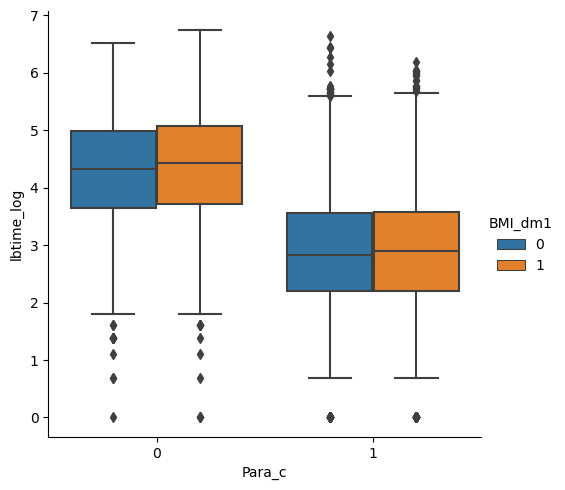

In [95]:
sns.catplot(data=df_p, x='Para_c', y='lbtime_log', hue='BMI_dm1', kind='box');

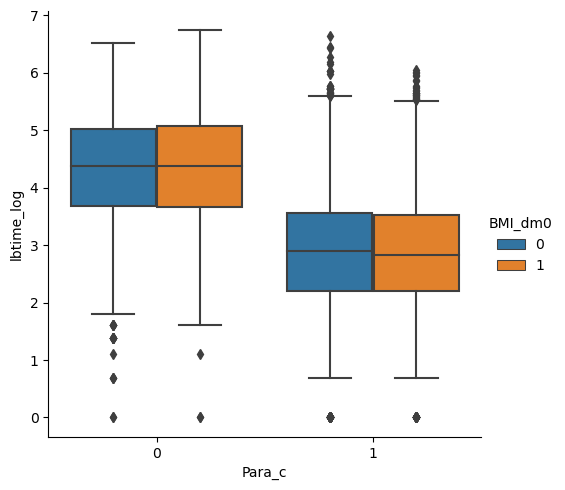

In [96]:
sns.catplot(data=df_p, x='Para_c', y='lbtime_log', hue='BMI_dm0', kind='box');

In [97]:
model = ols('lbtime_log ~ C(BMI_dm1) + C(Para_c) + C(BMI_dm1):C(Para_c)', data=df_p).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                           sum_sq      df            F    PR(>F)
C(BMI_dm1)               2.842901     1.0     2.656315  0.103173
C(Para_c)             4623.645550     1.0  4320.185224  0.000000
C(BMI_dm1):C(Para_c)     3.622921     1.0     3.385140  0.065818
Residual              9936.130759  9284.0          NaN       NaN


In [98]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lbtime_log   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     1443.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:21:00   Log-Likelihood:                -13492.
No. Observations:                9288   AIC:                         2.699e+04
Df Residuals:                    9284   BIC:                         2.702e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          4.2782      0.026    165.779      0.000       4.228       4.329
C(BMI_dm1)[T.1]                    0.0834      0.034      2.457      0.014       0.017       0.150
C(Para_c)[T.1]                    -1.3885      0.033    -41.623      0.000      -1.454      -1.323
C(BMI_dm1)[T.1]:C(Para_c)[T.1]    -0.0812      0.044     -1.840      0.066      -0.168       0.005
==============================================================================
Omnibus:                       39.131   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.671
Skew:                          -0.091   Prob(JB):                     7.34e-11
Kurtosis:                       3.295   Cond. No.                         8.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
model = ols('lbtime_log ~ C(BMI_dm0) + C(Para_c) + C(BMI_dm0):C(Para_c)', data=df_p).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                           sum_sq      df            F    PR(>F)
C(BMI_dm0)               3.741546     1.0     3.495029  0.061585
C(Para_c)             4619.471541     1.0  4315.110857  0.000000
C(BMI_dm0):C(Para_c)     0.020274     1.0     0.018939  0.890546
Residual              9938.834761  9284.0          NaN       NaN


In [100]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lbtime_log   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     1442.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:21:00   Log-Likelihood:                -13494.
No. Observations:                9288   AIC:                         2.700e+04
Df Residuals:                    9284   BIC:                         2.702e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          4.3369      0.019    223.336      0.000       4.299       4.375
C(BMI_dm0)[T.1]                   -0.0413      0.039     -1.072      0.284      -0.117       0.034
C(Para_c)[T.1]                    -1.4327      0.025    -56.370      0.000      -1.483      -1.383
C(BMI_dm0)[T.1]:C(Para_c)[T.1]    -0.0068      0.050     -0.138      0.891      -0.104       0.091
==============================================================================
Omnibus:                       37.779   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.095
Skew:                          -0.088   Prob(JB):                     1.61e-10
Kurtosis:                       3.292   Cond. No.                         7.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
model = ols('lbtime_log ~ C(BMI_dm0) +C(BMI_dm1)+ C(Para_c) + C(BMI_dm0):C(Para_c)+C(BMI_dm1):C(Para_c)++C(BMI_dm1):C(BMI_dm0)', data=df_p).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                            sum_sq      df            F    PR(>F)
C(BMI_dm0)               10.444514     1.0     9.769925  0.001779
C(BMI_dm1)                9.861577     1.0     9.224639  0.002394
C(Para_c)              4594.971973     1.0  4298.192503  0.000000
C(BMI_dm0):C(Para_c)      0.986133     1.0     0.922440  0.336860
C(BMI_dm1):C(Para_c)      4.496571     1.0     4.206147  0.040306
C(BMI_dm1):C(BMI_dm0)     3.097827     1.0     2.897745  0.088737
Residual               9921.829896  9281.0          NaN       NaN


In [102]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lbtime_log   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     724.7
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:21:00   Log-Likelihood:                -13486.
No. Observations:                9288   AIC:                         2.699e+04
Df Residuals:                    9281   BIC:                         2.704e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           4.2786      0.026    165.882      0.000       4.228       4.329
C(BMI_dm0)[T.1]                    -0.5919      0.282     -2.097      0.036      -1.145      -0.039
C(BMI_dm1)[T.1]                     0.1342      0.039      3.431      0.001       0.058       0.211
C(Para_c)[T.1]                     -1.3860      0.033    -41.537      0.000      -1.451      -1.321
C(BMI_dm0)[T.1]:C(Para_c)[T.1]      0.0556      0.058      0.960      0.337      -0.058       0.169
C(BMI_dm1)[T.1]:C(Para_c)[T.1]     -0.1055      0.051     -2.051      0.040      -0.206      -0.005
C(BMI_dm1)[T.1]:C(BMI_dm0)[T.1]     0.4753      0.279      1.702      0.089      -0.072       1.023
==============================================================================
Omnibus:                       38.750   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.455
Skew:                          -0.089   Prob(JB):                     8.17e-11
Kurtosis:                       3.297   Cond. No.                         55.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""